In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'

In [2]:
!kaggle datasets download -d adityajn105/flickr8k

100% 1.04G/1.04G [00:45<00:00, 23.5MB/s]
100% 1.04G/1.04G [00:45<00:00, 24.2MB/s]


In [3]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, ResNet50V2, ResNet101  # Import ResNet101
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [5]:
plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')
image_path = 'Images'

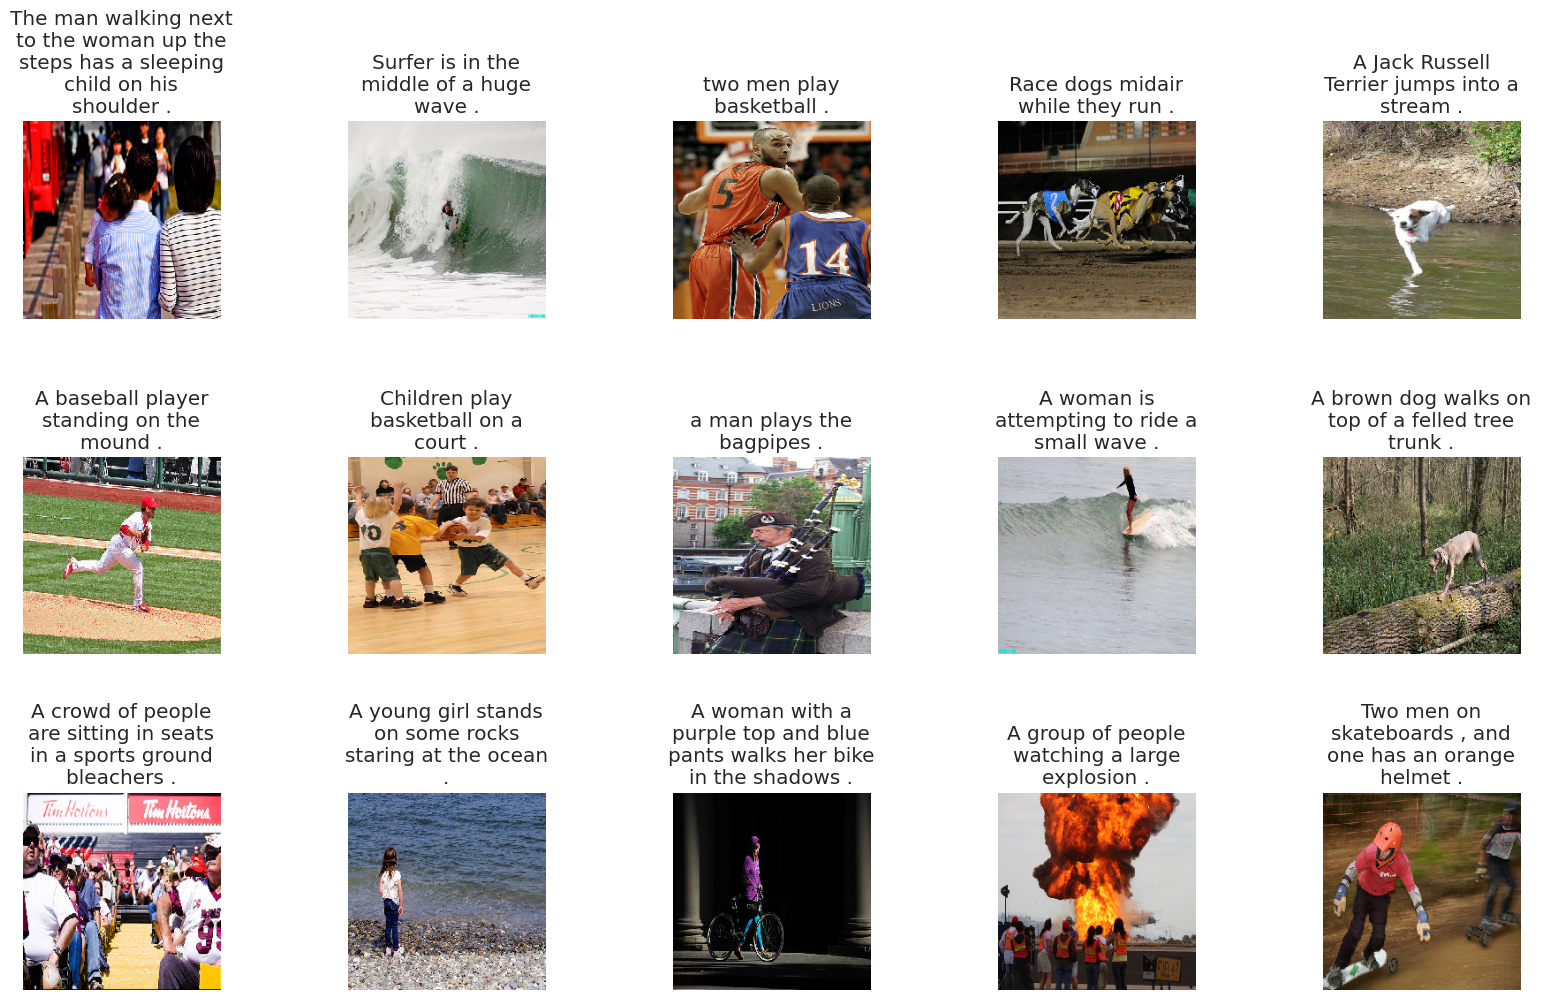

In [6]:
# Load captions data
data = pd.read_csv("captions.txt")

# Read and preprocess images
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    return img
def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")
display_images(data.sample(15))

In [7]:
# Preprocess captions
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: "startseq "+x+" endseq")
    return data
data = text_preprocessing(data)
captions = data['caption'].tolist()

In [8]:
# Tokenize captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)
# Split data into train and test sets
images = data['image'].unique().tolist()
nimages = len(images)
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)


In [9]:
model = ResNet101()  # Use ResNet101 instead of ResNet50
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

179648224/179648224 [==============================] - 9s 0us/step


In [10]:
# Extract image features
img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature


100%|██████████| 8091/8091 [14:06<00:00,  9.56it/s]


In [11]:
# Define data augmentation for images added new
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [12]:
# Custom data generator with data augmentation
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features, shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        self.image_generator = train_datagen.flow_from_dataframe(
            dataframe=self.df,
            directory=image_path,
            x_col=self.X_col,
            y_col=self.y_col,
            target_size=(img_size, img_size),
            batch_size=self.batch_size,
            seed=42,
            shuffle=True,
            class_mode='input'
        )

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self, index):
        batch = self.image_generator.next()
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self, batch):
        X1, X2, y = list(), list(), list()
        images = batch[0]

        for i, img in enumerate(images):
            feature = self.features[self.df[self.X_col].iloc[i]][0]
            captions = self.df[self.y_col].iloc[i]
            seq = self.tokenizer.texts_to_sequences([captions])[0]

            for j in range(1,len(seq)):
                in_seq, out_seq = seq[:j], seq[j]
                in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                X1.append(feature)
                X2.append(in_seq)
                y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        return X1, X2, y


In [13]:
# Define model architecture
input1 = Input(shape=(2048,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
# Create data generators for training and validation
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

# Define callbacks for model training
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only=True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta=0, patience=5, verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)


Found 34385 validated image filenames.
Found 6070 validated image filenames.


In [14]:
# Train the model
history = caption_model.fit(
        train_generator,
        epochs=5,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/5
537/537 [==============================] - ETA: 0s - loss: 2.3665
Epoch 1: val_loss improved from inf to 15.40060, saving model to model.h5
537/537 [==============================] - 684s 1s/step - loss: 2.3665 - val_loss: 15.4006 - lr: 0.0010
Epoch 2/5
537/537 [==============================] - ETA: 0s - loss: 1.2944
Epoch 2: val_loss did not improve from 15.40060
537/537 [==============================] - 624s 1s/step - loss: 1.2944 - val_loss: 16.1827 - lr: 0.0010
Epoch 3/5
537/537 [==============================] - ETA: 0s - loss: 1.4030
Epoch 3: val_loss improved from 15.40060 to 14.87912, saving model to model.h5
537/537 [==============================] - 631s 1s/step - loss: 1.4030 - val_loss: 14.8791 - lr: 0.0010
Epoch 4/5
537/537 [==============================] - ETA: 0s - loss: 1.4615
Epoch 4: val_loss improved from 14.87912 to 14.06491, saving model to model.h5
537/537 [==============================] - 638s 1s/step - loss: 1.4615 - val_loss: 14.0649 - lr: 0.0010


In [ ]:
# Plot training history
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
def idx_to_word(integer,tokenizer):
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

def predict_caption(model, image, tokenizer, max_length, features):
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

1/1 [==============================] - 0s 79ms/step


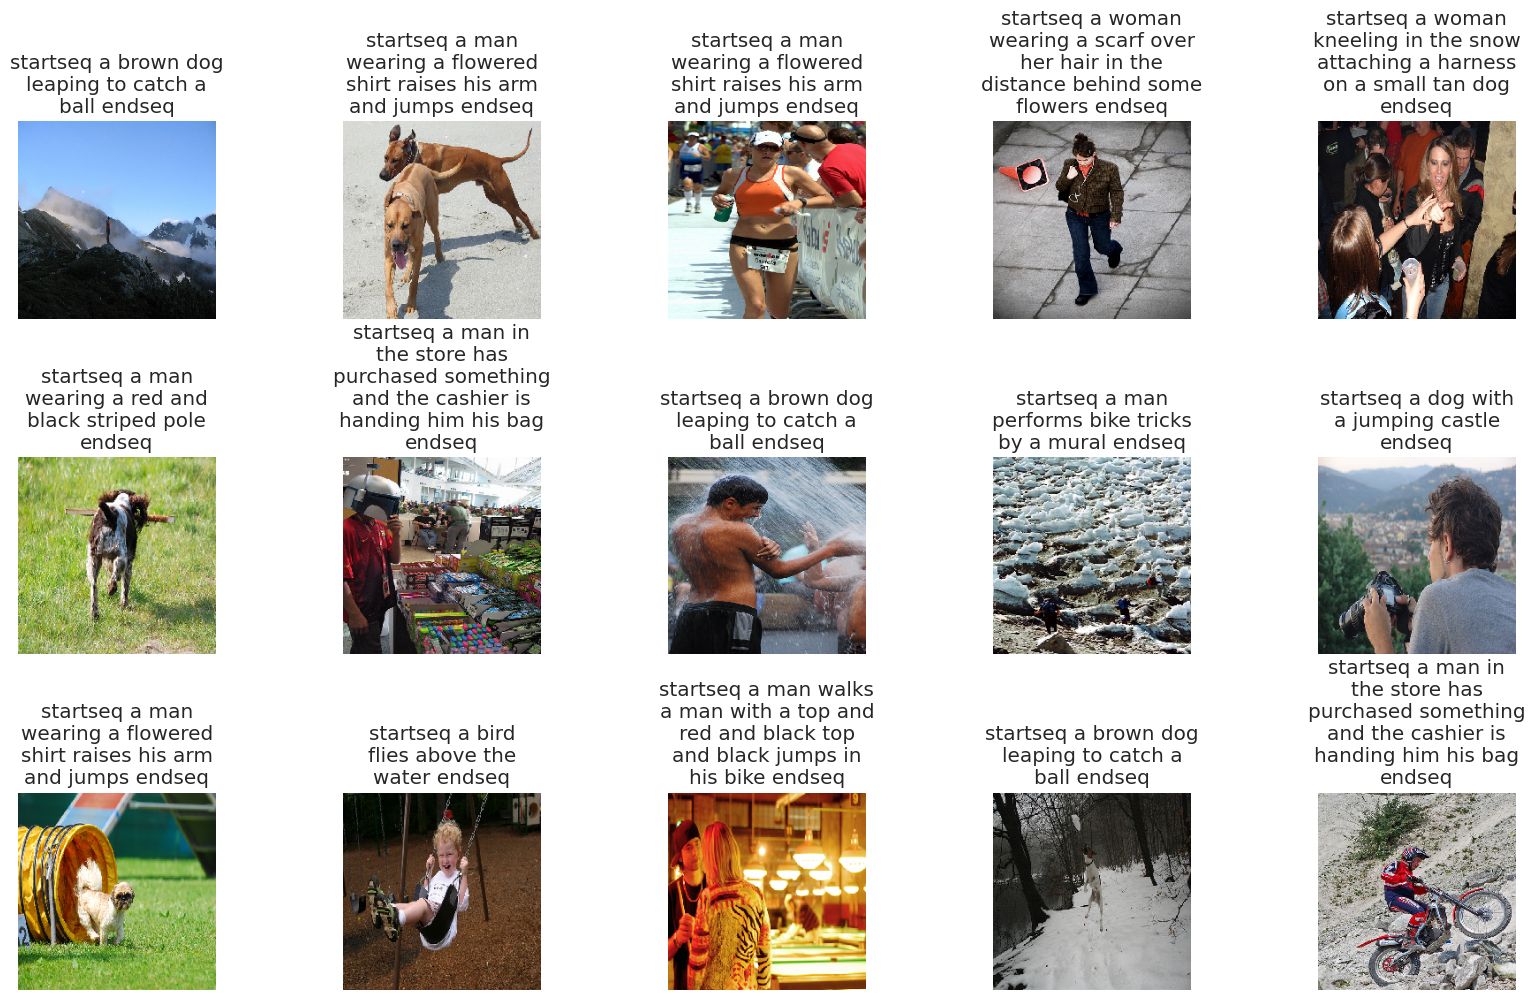

In [17]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)
for index,record in samples.iterrows():
    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption
display_images(samples)

In [27]:
import nltk
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [28]:
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import numpy as np
import pandas as pd

# METEOR score
meteor_scores = []
for idx, record in samples.iterrows():
    reference = [caption.split() for caption in test[test['image'] == record['image']]['caption'].tolist()]
    hypothesis = record['caption'].split()
    score = meteor_score(reference, hypothesis)
    meteor_scores.append(score)
mean_meteor_score = np.mean(meteor_scores)
print("Mean METEOR Score:", mean_meteor_score)

# BLEU score
bleu_scores = []
smooth = SmoothingFunction().method1  # Define smoothing function
for idx, record in samples.iterrows():
    reference = [caption.split() for caption in test[test['image'] == record['image']]['caption'].tolist()]
    hypothesis = record['caption'].split()
    score = corpus_bleu([reference], [hypothesis], smoothing_function=smooth)
    bleu_scores.append(score)
mean_bleu_score = np.mean(bleu_scores)
print("Mean BLEU Score:", mean_bleu_score)


Mean METEOR Score: 0.28420375874865683
Mean BLEU Score: 0.07368674098180969


In [30]:
!pip install rouge


In [32]:

# Calculate ROUGE scores
rouge_scores = {'rouge-1': [], 'rouge-2': [], 'rouge-l': []}
for idx, record in samples.iterrows():
    reference = ' '.join([caption for caption in test[test['image'] == record['image']]['caption'].tolist()])
    hypothesis = record['caption']
    scores = rouge.get_scores(hypothesis, reference)
    rouge_scores['rouge-1'].append(scores[0]['rouge-1']['f'])
    rouge_scores['rouge-2'].append(scores[0]['rouge-2']['f'])
    rouge_scores['rouge-l'].append(scores[0]['rouge-l']['f'])

# Calculate mean ROUGE scores
mean_rouge_1 = np.mean(rouge_scores['rouge-1'])
mean_rouge_2 = np.mean(rouge_scores['rouge-2'])
mean_rouge_l = np.mean(rouge_scores['rouge-l'])

print("Mean ROUGE-1 Score:", mean_rouge_1)
print("Mean ROUGE-2 Score:", mean_rouge_2)
print("Mean ROUGE-L Score:", mean_rouge_l)


Mean ROUGE-1 Score: 0.24306391320889892
Mean ROUGE-2 Score: 0.06005737884996845
Mean ROUGE-L Score: 0.22868347012257348
